In [1]:
import numpy as np
from scipy import linalg as la
from matplotlib import pyplot as plt
from imageio import imread


# Problem 1
def compact_svd(A, tol=1e-6):
    """Compute the truncated SVD of A.

    Parameters:
        A ((m,n) ndarray): The matrix (of rank r) to factor.
        tol (float): The tolerance for excluding singular values.

    Returns:
        ((m,r) ndarray): The orthonormal matrix U in the SVD.
        ((r,) ndarray): The singular values of A as a 1-D array.
        ((r,n) ndarray): The orthonormal matrix V^H in the SVD.
    """
    eigs, vectors = la.eig(A.conj().T @ A)       #get the eigenvalues and eigenvectors of A hermitian times A

    sings = np.sqrt(eigs)

    sorting_indices = np.flip(np.argsort(sings))    #arrange the singular values in descending order

    sings = sings[sorting_indices]         #arrange the singular values in descending order

    vectors = vectors[:,sorting_indices]           #arrange the vectors so that they correspond to the singular values

    rank = np.count_nonzero(sings > tol)           #calculate the rank by the amount of singular values greater than the tolerance

    sings1 = sings[:rank]

    vectors1 = vectors[:,:rank]                    #keep the positive singular values and corresponding columns of V

    U_one = (A @ vectors1) / sings1               #construct U with the given formula

    return U_one, sings1, vectors1.conj().T

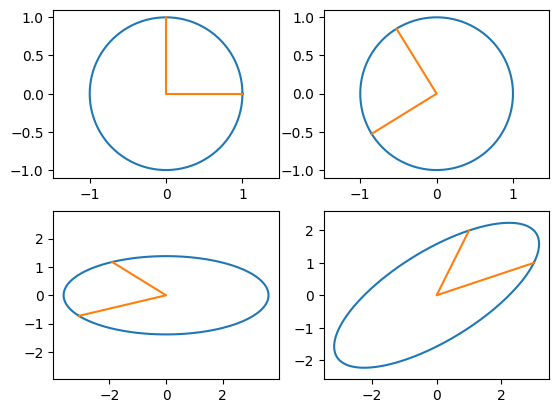

In [6]:
# Problem 2
def visualize_svd(A):
    """Plot the effect of the SVD of A as a sequence of linear transformations
    on the unit circle and the two standard basis vectors.
    """
    E = np.array([[1,0,0], [0,0,1]])

    domain = np.linspace(0, 2*np.pi, 200)           #construct our domain of 200 points from 0 to 2pi
    x = np.cos(domain)
    y = np.sin(domain)

    S = np.vstack((x,y))         #put the x and y coordinates of the unit circle in a matrix

    U, Sig, V = la.svd(A)

    Sig = np.diag(Sig)

    ax1 = plt.subplot(221)      #plot the orignal S and E
    plt.plot(S[0], S[1])
    plt.plot(E[0], E[1])
    plt.axis("equal")

    ax2 = plt.subplot(222)      #plot how each part of the SVD affects S and E
    plt.plot((V @ S)[0], (V @ S)[1])
    plt.plot((V @ E)[0], (V @ E)[1])
    plt.axis("equal")

    ax3 = plt.subplot(223)
    plt.plot((Sig @ V @ S)[0], (Sig @ V @ S)[1])
    plt.plot((Sig @ V @ E)[0], (Sig @ V @ E)[1])
    plt.axis("equal")

    ax4 = plt.subplot(224)
    plt.plot((U @ Sig @ V @ S)[0], (U @ Sig @ V @ S)[1])
    plt.plot((U @ Sig @ V @ E)[0], (U @ Sig @ V @ E)[1])
    plt.axis("equal")

    plt.show()
A = np.array([[3,1],[1,2]])
visualize_svd(A)

In [3]:
# Problem 3
def svd_approx(A, s):
    """Return the best rank s approximation to A with respect to the 2-norm
    and the Frobenius norm, along with the number of bytes needed to store
    the approximation via the truncated SVD.

    Parameters:
        A ((m,n), ndarray)
        s (int): The rank of the desired approximation.

    Returns:
        ((m,n), ndarray) The best rank s approximation of A.
        (int) The number of entries needed to store the truncated SVD.
    """

    if s > np.linalg.matrix_rank(A):
        raise ValueError("s cannot be greater than the number of nonzero singular values of A")

    U, Sig, V = la.svd(A)

    Sig = Sig[:s]        #keep only the singular values that correspond to the given rank

    U = U[:, :s]         #only keep the columns of U that correspond to the given rank

    V = V[:s,:]          #only keep the columns of V that correspond to the given rank

    num_entries = Sig.size + U.size + V.size   #calculate the size of the best approximation by summing the sizes of each component

    Sig = np.diag(Sig)

    best_approx = U @ Sig @ V

    return best_approx, num_entries

In [4]:
# Problem 4
def lowest_rank_approx(A, err):
    """Return the lowest rank approximation of A with error less than 'err'
    with respect to the matrix 2-norm, along with the number of bytes needed
    to store the approximation via the truncated SVD.

    Parameters:
        A ((m, n) ndarray)
        err (float): Desired maximum error.

    Returns:
        A_s ((m,n) ndarray) The lowest rank approximation of A satisfying
            ||A - A_s||_2 < err.
        (int) The number of entries needed to store the truncated SVD.
    """
    U, Sigs, V = la.svd(A)

    if err <= np.min(Sigs):
        raise ValueError("error has to be greater than the smallest singular value")  #raise an error if the error is less than or equal to the smallest singular value

    s = np.min(np.where(Sigs < err))     #find the index of the smallest singular value less than the error 

    Sigs = Sigs[:s]     #truncate the singular values, and columns of U and V according to the found index

    U = U[:, :s]

    V = V[:s,:]

    num_entries = Sigs.size + U.size + V.size                  #calculate the number of entries needed to store the lowest rank approximation

    Sig = np.diag(Sigs)

    best_approx = U @ Sig @ V

    return best_approx, num_entries

In [5]:
# Problem 5
def compress_image(filename, s):
    """Plot the original image found at 'filename' and the rank s approximation
    of the image found at 'filename.' State in the figure title the difference
    in the number of entries used to store the original image and the
    approximation.

    Parameters:
        filename (str): Image file path.
        s (int): Rank of new image.
    """

    image = imread(filename) / 255        #scale the image matrix

    if np.ndim(image) < 3:      #if the image matrix is less than 3 dimensions, then it is a gray image, so plot accordingly
        plt.subplot(121)
        plt.imshow(image, cmap="gray")
        plt.axis("off")

        A_s, new_size = svd_approx(image, s)      #get the svd approximation of the given rank and its size
        A_s = np.clip(A_s, 0, 1)

        plt.subplot(122)
        plt.imshow(A_s, cmap="gray")
        plt.axis("off")


    else:                            
        plt.subplot(121)
        plt.imshow(image)
        plt.axis("off")

        Red_s, red_size = svd_approx(image[:,:,0], s)        #get the svd approxmiation of elements for each color of the image matrix and the size of the stored pixels for each color
        Green_s, green_size = svd_approx(image[:,:,1], s)
        Blue_s, blue_size = svd_approx(image[:,:,2], s)
        A_s = np.dstack((Red_s, Green_s, Blue_s))            #put all the approximations back together into one matrix
        A_s = np.clip(A_s, 0, 1)                             #clip the matrix so that all entries are between 0 and 1

        new_size = red_size + green_size + blue_size         #sum the size of the stored pixels for each color in the approximation to get the total size

        plt.subplot(122)
        plt.imshow(A_s)
        plt.axis("off")

    difference_in_size = image.size - new_size              #calculate the difference in size between the orginal image and the svd compression

    plt.suptitle(str(difference_in_size))
    
    plt.show()

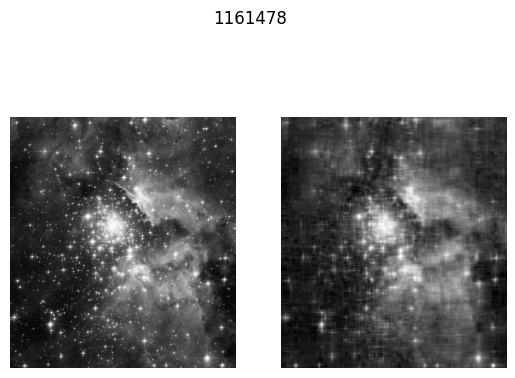

In [7]:
compress_image('hubble_gray.jpg', 20)